In [63]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pathlib
from lb2jpsil import lorentz
import random
from typing import Tuple
from scipy import optimize, integrate, stats
import time
import ROOT

In [2]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [3]:
## in eV
m_electron = 0.511e6
m_lambda = 1116e6

## in eV/T
bohr_magneton = 5.788e-5

## in eV s
hbar = 6.582e-16

## in m/s
c = 299792458.

In [5]:
f = ROOT.TF1Convolution("expo", "gaus", -1, 6, True)

In [6]:
a = ROOT.TF1("f", f, 0., 5., f.GetNpar());

In file included from input_line_97:1:
/home/adegenna/.local/opt/root-6.24.06/include/CPyCppyy/API.h:30:10: fatal error: 'Python.h' file not found
#include "Python.h"
         ^~~~~~~~~~
In file included from input_line_98:1:
/home/adegenna/.local/opt/root-6.24.06/include/CPyCppyy/API.h:30:10: fatal error: 'Python.h' file not found
#include "Python.h"
         ^~~~~~~~~~
In file included from input_line_99:1:
/home/adegenna/.local/opt/root-6.24.06/include/CPyCppyy/API.h:30:10: fatal error: 'Python.h' file not found
#include "Python.h"
         ^~~~~~~~~~
In file included from input_line_100:1:
/home/adegenna/.local/opt/root-6.24.06/include/CPyCppyy/API.h:30:10: fatal error: 'Python.h' file not found
#include "Python.h"
         ^~~~~~~~~~


In [7]:
a.SetParameters(1., -0.3, 0., 1.)

In [8]:
xs = np.linspace(-1,6)

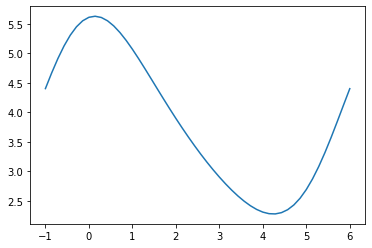

In [9]:
plt.plot(xs, [a.Eval(x) for x in xs])

In [10]:
def scalar_product(v1, v2):
    return v1[0] * v2[0] + v1[1] * v2[1] + v1[2] * v2[2]

In [11]:
## in eV
m_electron = 0.511e6
m_lambda = 1116e6

## in eV/T
bohr_magneton = 5.788e-5

## in eV s
hbar = 6.582e-16

## in m/s
c = 299792458.

In [12]:
## Assuming EDM is 0
def particle_magneton(m_particle):
    return bohr_magneton * m_electron / m_lambda

def phi_rot(g: float, Dy: float, beta: float, m_particle: float):
    muB = particle_magneton(m_particle)
    return g * Dy * muB / (beta * hbar * c)

In [13]:
def pdf(cos_theta, phi, sz=1, g=1.226, Dy=4, beta=1.):
    alpha = 0.732
    
    Phi_rot = phi_rot(g, Dy, beta, m_lambda)
    
    s = np.array([
        - sz * np.sin(Phi_rot),
        0,
        sz * np.cos(Phi_rot)
    ])
    
    k_hat = np.array([
        np.sin(np.arccos(cos_theta)) * np.cos(phi),
        np.sin(np.arccos(cos_theta)) * np.sin(phi),
        cos_theta
    ])
    
    return 1 + alpha * scalar_product(s, k_hat)

In [14]:
stats.norm.pdf(0, 0, 1)

0.3989422804014327

In [15]:
def convoluted_with_ctheta(ctheta, phi, epsrel=1.49e-08):
    y, _ = integrate.quad(lambda t: pdf(t, phi) * stats.norm.pdf(ctheta - t, 0, 0.253), -1 ,1, epsrel=epsrel)
    return y
    
def convoluted_with_ctheta_and_phi(ctheta, phi, epsrel=1.49e-08):
    y, _ = integrate.quad(lambda t: convoluted_with_ctheta(ctheta, t, epsrel=epsrel) * stats.norm.pdf(phi - t, 0, 1.083), -np.pi ,np.pi, epsrel=epsrel)
    return y

def convoluted_pdf(ctheta, phi, epsrel=1.49e-08):
    return np.vectorize(convoluted_with_ctheta_and_phi)(ctheta, phi, epsrel=epsrel)

In [16]:
tick = time.perf_counter()
print(convoluted_with_ctheta_and_phi(0,0))
tock = time.perf_counter()
print(tock - tick)

0.7539469422954491
2.4591719452291727


In [17]:
tick = time.perf_counter()
print(convoluted_with_ctheta_and_phi(0,0, epsrel=1e-3))
tock = time.perf_counter()
print(tock - tick)

0.7539469364786836
0.12094683572649956


In [18]:
tick = time.perf_counter()
print(convoluted_with_ctheta_and_phi(0,0, epsrel=2))
tock = time.perf_counter()
print(tock - tick)

0.7539469364786836
0.12446595542132854


In [19]:
import threadpoolctl

In [20]:
tick = time.perf_counter()

In [21]:
theta_min = -1
theta_max = 1

phi_min = -np.pi
phi_max = np.pi

bins = 30

theta_list = np.linspace(theta_min, theta_max, bins)
phi_list = np.linspace(phi_min, phi_max, bins)

theta_grid, phi_grid = np.meshgrid(theta_list, phi_list)
ys = convoluted_pdf(theta_grid, phi_grid, epsrel=1e-2)

In [22]:
tock = time.perf_counter()
tock - tick

61.7315164282918

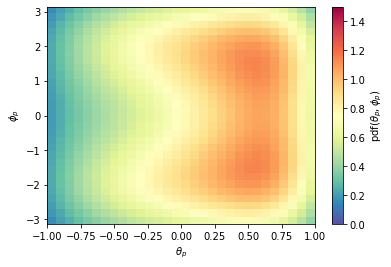

In [23]:
plt.imshow(ys,extent=[theta_min, theta_max, phi_min, phi_max], cmap='Spectral_r', origin='lower', aspect='auto')
#plt.imshow(ys, cmap='Spectral_r', origin='lower')

plt.clim(0,1.5)
plt.colorbar(label=r"$\mathrm{pdf}(\theta_p,\phi_p)$")
plt.xlabel(r"$\theta_p$")
plt.ylabel(r"$\phi_p$")
plt.show()

In [24]:
def h(ctheta, phi):
    y, _ = integrate.quad(lambda t: pdf(t, phi) * stats.norm.pdf(ctheta - t, 0, 0.253), -1 ,1, epsrel=1e-3)
    return y

In [25]:
def convoluted(ctheta, phi):
    y, _ = integrate.quad(lambda t: h(ctheta, t) * stats.norm.pdf(phi - t, 0, 1.083), -np.pi ,np.pi, epsrel=1e-3)
    return y

In [26]:
convoluted(0,0)

0.7539469364786836

In [27]:
convoluted_vectorized = np.vectorize(convoluted)

In [28]:
tick = time.perf_counter()
print(convoluted_vectorized(1,0))
tock = time.perf_counter()

0.6600631289848735


In [29]:
tock - tick

0.8749787528067827

In [30]:
a.Eval(2)

3.8982823402521345

In [31]:
convoluted(1,0)

0.6600631289848735

In [32]:
h(1,0)

0.6091119664670708

In [33]:
pdf(1,0)

1.578878029208671

In [34]:
pdf(1,1)

1.578878029208671

In [36]:
for t, p in zip(theta_grid, phi_grid):
    for i, j in zip(t, p):
        print(i,j)

-1.0 -3.141592653589793
-0.9797979797979798 -3.141592653589793
-0.9595959595959596 -3.141592653589793
-0.9393939393939394 -3.141592653589793
-0.9191919191919192 -3.141592653589793
-0.898989898989899 -3.141592653589793
-0.8787878787878788 -3.141592653589793
-0.8585858585858586 -3.141592653589793
-0.8383838383838383 -3.141592653589793
-0.8181818181818181 -3.141592653589793
-0.797979797979798 -3.141592653589793
-0.7777777777777778 -3.141592653589793
-0.7575757575757576 -3.141592653589793
-0.7373737373737373 -3.141592653589793
-0.7171717171717171 -3.141592653589793
-0.696969696969697 -3.141592653589793
-0.6767676767676767 -3.141592653589793
-0.6565656565656566 -3.141592653589793
-0.6363636363636364 -3.141592653589793
-0.6161616161616161 -3.141592653589793
-0.5959595959595959 -3.141592653589793
-0.5757575757575757 -3.141592653589793
-0.5555555555555556 -3.141592653589793
-0.5353535353535352 -3.141592653589793
-0.5151515151515151 -3.141592653589793
-0.4949494949494949 -3.141592653589793
-0.4

0.21212121212121215 -2.5703939893007397
0.2323232323232325 -2.5703939893007397
0.2525252525252526 -2.5703939893007397
0.27272727272727293 -2.5703939893007397
0.29292929292929304 -2.5703939893007397
0.31313131313131315 -2.5703939893007397
0.3333333333333335 -2.5703939893007397
0.3535353535353536 -2.5703939893007397
0.3737373737373739 -2.5703939893007397
0.39393939393939403 -2.5703939893007397
0.41414141414141437 -2.5703939893007397
0.4343434343434345 -2.5703939893007397
0.4545454545454546 -2.5703939893007397
0.4747474747474749 -2.5703939893007397
0.49494949494949503 -2.5703939893007397
0.5151515151515154 -2.5703939893007397
0.5353535353535355 -2.5703939893007397
0.5555555555555556 -2.5703939893007397
0.5757575757575759 -2.5703939893007397
0.595959595959596 -2.5703939893007397
0.6161616161616164 -2.5703939893007397
0.6363636363636365 -2.5703939893007397
0.6565656565656568 -2.5703939893007397
0.6767676767676769 -2.5703939893007397
0.696969696969697 -2.5703939893007397
0.7171717171717173 -

0.7373737373737375 -1.872262288503008
0.7575757575757578 -1.872262288503008
0.7777777777777779 -1.872262288503008
0.7979797979797982 -1.872262288503008
0.8181818181818183 -1.872262288503008
0.8383838383838385 -1.872262288503008
0.8585858585858588 -1.872262288503008
0.8787878787878789 -1.872262288503008
0.8989898989898992 -1.872262288503008
0.9191919191919193 -1.872262288503008
0.9393939393939394 -1.872262288503008
0.9595959595959598 -1.872262288503008
0.9797979797979799 -1.872262288503008
1.0 -1.872262288503008
-1.0 -1.8087957702486688
-0.9797979797979798 -1.8087957702486688
-0.9595959595959596 -1.8087957702486688
-0.9393939393939394 -1.8087957702486688
-0.9191919191919192 -1.8087957702486688
-0.898989898989899 -1.8087957702486688
-0.8787878787878788 -1.8087957702486688
-0.8585858585858586 -1.8087957702486688
-0.8383838383838383 -1.8087957702486688
-0.8181818181818181 -1.8087957702486688
-0.797979797979798 -1.8087957702486688
-0.7777777777777778 -1.8087957702486688
-0.7575757575757576 

-0.2727272727272727 -1.0471975511965974
-0.2525252525252525 -1.0471975511965974
-0.23232323232323226 -1.0471975511965974
-0.21212121212121204 -1.0471975511965974
-0.19191919191919182 -1.0471975511965974
-0.1717171717171716 -1.0471975511965974
-0.1515151515151515 -1.0471975511965974
-0.13131313131313127 -1.0471975511965974
-0.11111111111111105 -1.0471975511965974
-0.09090909090909083 -1.0471975511965974
-0.07070707070707061 -1.0471975511965974
-0.050505050505050386 -1.0471975511965974
-0.030303030303030276 -1.0471975511965974
-0.010101010101010055 -1.0471975511965974
0.010101010101010166 -1.0471975511965974
0.030303030303030498 -1.0471975511965974
0.05050505050505061 -1.0471975511965974
0.07070707070707072 -1.0471975511965974
0.09090909090909105 -1.0471975511965974
0.11111111111111116 -1.0471975511965974
0.1313131313131315 -1.0471975511965974
0.1515151515151516 -1.0471975511965974
0.1717171717171717 -1.0471975511965974
0.19191919191919204 -1.0471975511965974
0.21212121212121215 -1.04719

-0.09090909090909083 -0.34906585039886595
-0.07070707070707061 -0.34906585039886595
-0.050505050505050386 -0.34906585039886595
-0.030303030303030276 -0.34906585039886595
-0.010101010101010055 -0.34906585039886595
0.010101010101010166 -0.34906585039886595
0.030303030303030498 -0.34906585039886595
0.05050505050505061 -0.34906585039886595
0.07070707070707072 -0.34906585039886595
0.09090909090909105 -0.34906585039886595
0.11111111111111116 -0.34906585039886595
0.1313131313131315 -0.34906585039886595
0.1515151515151516 -0.34906585039886595
0.1717171717171717 -0.34906585039886595
0.19191919191919204 -0.34906585039886595
0.21212121212121215 -0.34906585039886595
0.2323232323232325 -0.34906585039886595
0.2525252525252526 -0.34906585039886595
0.27272727272727293 -0.34906585039886595
0.29292929292929304 -0.34906585039886595
0.31313131313131315 -0.34906585039886595
0.3333333333333335 -0.34906585039886595
0.3535353535353536 -0.34906585039886595
0.3737373737373739 -0.34906585039886595
0.393939393939

0.7373737373737375 0.6663984416705624
0.7575757575757578 0.6663984416705624
0.7777777777777779 0.6663984416705624
0.7979797979797982 0.6663984416705624
0.8181818181818183 0.6663984416705624
0.8383838383838385 0.6663984416705624
0.8585858585858588 0.6663984416705624
0.8787878787878789 0.6663984416705624
0.8989898989898992 0.6663984416705624
0.9191919191919193 0.6663984416705624
0.9393939393939394 0.6663984416705624
0.9595959595959598 0.6663984416705624
0.9797979797979799 0.6663984416705624
1.0 0.6663984416705624
-1.0 0.7298649599249014
-0.9797979797979798 0.7298649599249014
-0.9595959595959596 0.7298649599249014
-0.9393939393939394 0.7298649599249014
-0.9191919191919192 0.7298649599249014
-0.898989898989899 0.7298649599249014
-0.8787878787878788 0.7298649599249014
-0.8585858585858586 0.7298649599249014
-0.8383838383838383 0.7298649599249014
-0.8181818181818181 0.7298649599249014
-0.797979797979798 0.7298649599249014
-0.7777777777777778 0.7298649599249014
-0.7575757575757576 0.7298649599

0.7171717171717173 1.6183962154856513
0.7373737373737375 1.6183962154856513
0.7575757575757578 1.6183962154856513
0.7777777777777779 1.6183962154856513
0.7979797979797982 1.6183962154856513
0.8181818181818183 1.6183962154856513
0.8383838383838385 1.6183962154856513
0.8585858585858588 1.6183962154856513
0.8787878787878789 1.6183962154856513
0.8989898989898992 1.6183962154856513
0.9191919191919193 1.6183962154856513
0.9393939393939394 1.6183962154856513
0.9595959595959598 1.6183962154856513
0.9797979797979799 1.6183962154856513
1.0 1.6183962154856513
-1.0 1.6818627337399903
-0.9797979797979798 1.6818627337399903
-0.9595959595959596 1.6818627337399903
-0.9393939393939394 1.6818627337399903
-0.9191919191919192 1.6818627337399903
-0.898989898989899 1.6818627337399903
-0.8787878787878788 1.6818627337399903
-0.8585858585858586 1.6818627337399903
-0.8383838383838383 1.6818627337399903
-0.8181818181818181 1.6818627337399903
-0.797979797979798 1.6818627337399903
-0.7777777777777778 1.68186273373

-0.9393939393939394 2.633860507555079
-0.9191919191919192 2.633860507555079
-0.898989898989899 2.633860507555079
-0.8787878787878788 2.633860507555079
-0.8585858585858586 2.633860507555079
-0.8383838383838383 2.633860507555079
-0.8181818181818181 2.633860507555079
-0.797979797979798 2.633860507555079
-0.7777777777777778 2.633860507555079
-0.7575757575757576 2.633860507555079
-0.7373737373737373 2.633860507555079
-0.7171717171717171 2.633860507555079
-0.696969696969697 2.633860507555079
-0.6767676767676767 2.633860507555079
-0.6565656565656566 2.633860507555079
-0.6363636363636364 2.633860507555079
-0.6161616161616161 2.633860507555079
-0.5959595959595959 2.633860507555079
-0.5757575757575757 2.633860507555079
-0.5555555555555556 2.633860507555079
-0.5353535353535352 2.633860507555079
-0.5151515151515151 2.633860507555079
-0.4949494949494949 2.633860507555079
-0.4747474747474747 2.633860507555079
-0.4545454545454545 2.633860507555079
-0.43434343434343425 2.633860507555079
-0.41414141414

In [37]:
a = ROOT.TF1("fa1","sin(x)/x",0,10)
b = ROOT.TF1("fa2","sin(x)/(2*x)",0,10)

In [38]:
xs = np.linspace(0,10)

In [39]:
def eval_vectorized(tf1, xs):
    return np.vectorize(tf1)(xs)

In [40]:
eval_vectorized(a, xs)

/home/adegenna/apollo/lib64/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


array([        nan,  0.99307289,  0.97246416,  0.93868653,  0.89257761,
        0.83527514,  0.76818344,  0.69293215,  0.61132858,  0.52530521,
        0.43686402,  0.34801939,  0.26074138,  0.17690116,  0.09822029,
        0.02622535, -0.03779068, -0.09279917, -0.13805797, -0.17312417,
       -0.19785751, -0.21241429, -0.21723221, -0.21300698, -0.20066137,
       -0.18130811, -0.1562078 , -0.12672351, -0.09427343, -0.06028339,
       -0.0261407 ,  0.00684921,  0.03750185,  0.06478742,  0.08785804,
        0.10606798,  0.1189862 ,  0.12640109,  0.12831751,  0.1249464 ,
        0.1166876 ,  0.10410668,  0.08790678,  0.06889666,  0.04795606,
        0.02599998,  0.00394284, -0.01733587, -0.03702342, -0.05440211])

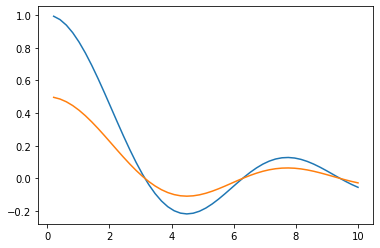

In [41]:
plt.plot(xs, [a.Eval(x) for x in xs])
plt.plot(xs, [b.Eval(x) for x in xs])
plt.show()

/home/adegenna/apollo/lib64/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/home/adegenna/apollo/lib64/python3.6/site-packages/numpy/lib/function_base.py:2192: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


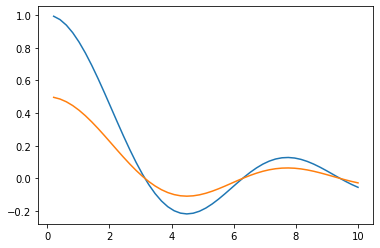

In [42]:
plt.plot(xs, eval_vectorized(a,xs))
plt.plot(xs, eval_vectorized(b,xs))
plt.show()

In [43]:
ctheta = ROOT.RooRealVar("ctheta", "ctheta", -1., 1.)
phi = ROOT.RooRealVar("phi", "phi", -np.pi, np.pi)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [44]:
#ROOT.RooClassFactory.makePdf("AngularDistribution", "ctheta,phi,sx,sz,alpha", "",
#                             "1+ alpha * (sx * sqrt(1-pow(ctheta,2)) * cos(phi) + sz * ctheta)"
#                            )

In [64]:
ROOT.gSystem.Load('libAngularDistribution.so')

1

In [65]:
ctheta = ROOT.RooRealVar("ctheta", "ctheta", 0.5, -1., 1.)
phi = ROOT.RooRealVar("phi", "phi", 0., -np.pi, np.pi)
alpha = ROOT.RooFit.RooConst( 0.732 )
sx = ROOT.RooRealVar('sx','sx',0.5,-1,1)
sz = ROOT.RooRealVar('sz','sz',1.,-1,1)

In [66]:
pdf = ROOT.AngularDistribution("pdf", "pdf", ctheta, phi, sx, sz, alpha)

In [67]:
pdf.evaluate()

1.6829652977851044

In [77]:
sigma_theta = ROOT.RooFit.RooConst(0.097)
mu_theta = ROOT.RooFit.RooConst(9.)

In [78]:
theta_gauss = ROOT.RooGaussian("theta_gauss", "theta_gauss", ctheta, mu_theta, sigma_theta)

In [79]:
theta_convoluted = ROOT.RooFFTConvPdf("theta_convoluted", "theta_convoluted", ctheta, pdf, theta_gauss)

In [80]:
theta_convoluted.getVal()

0.0

In [72]:
theta_convoluted.getVariables()